In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import warnings
import numpy as np
from dask.diagnostics import ProgressBar
import xarray as xr
import xhistogram
import xgcm
from xgcm import Grid
import matplotlib.pyplot as plt

In [14]:
print('numpy version', np.__version__, '\nxarray version', xr.__version__, '\nxhistogram version', xhistogram.__version__, '\nxgcm version', xgcm.__version__)

numpy version 1.26.4 
xarray version 2024.5.0 
xhistogram version 0.3.2 
xgcm version 0.8.2.dev15+g7492277


# Tutorial: evaluating water mass transformations from finite-volume tracer budget terms

In [15]:
import xwmt
print('xwmt version', xwmt.__version__)

xwmt version 0.2.1


### Load grids and data

In [16]:
dt = 'monthly' # choose from ['monthly', 'daily', 'hourly']
gridname = 'natv' # choose from ['zstr', 'natv', 'rho2']
# Caution: non-natv diagnostics are currently broken--see https://github.com/NCAR/MOM6/pull/215

# Load data
sim = "wmt_incsurffluxes.natv_rho2_zstr.monthly_daily_hourly.13months"
rootdir = f"/archive/Graeme.Macgilchrist/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/{sim}/Baltic_OM4_025/"
prefix = '19000101.ocean_'+dt+'_'
time = "190*"

# Merge diagnostics that were saved into different files into one main dataset
suffixs = ['surf','thck','heat','salt','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    if suffix == "surf":
        filename = prefix+suffix+'_'+time+'.nc'
    else:
        filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
    dsnow = xr.open_mfdataset(rootdir+filename, chunks={'time':1})
    ds = xr.merge([ds,dsnow])

# Select year-long subset
ds = ds.sel(time=slice('1900-02-01 00', '1901-02-01 00'))

#  Load grid
oceangridname = '19000101.ocean_static.nc'
ocean_grid = xr.open_dataset(rootdir+oceangridname).squeeze()

# Some renaming of variables to match conventions
ocean_grid = ocean_grid.rename({'depth_ocean':'deptho'})
ds = ds.rename({'temp':'thetao', 'salt':'so'})

In [17]:
# Add core coordinates of ocean_grid to ds
ds = ds.assign_coords({
    "areacello": xr.DataArray(ocean_grid["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
    "lon": xr.DataArray(ocean_grid["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "lat": xr.DataArray(ocean_grid["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'}
}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}
grid = Grid(ds.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)

**Note:** In addition to `grid` containing information about the static model grid, its attribute `grid._ds` points to the full dataset containing model diagnostics!

# Part 1. A minimal application of `xwmt`

### Watermass meta data

`xwmt` requires some basic information about water mass properties to compute Water Mass Transformations (WMT) in $\lambda$-coordinates.

In [18]:
metadata_dict = {
    "mass": {"lambda": "density", "thickness": "thkcello"},
    "heat": {"lambda": "thetao", "surface_lambda": "tos"},
    "salt": {"lambda": "so", "surface_lambda": "sos"}
}

### Computing WMTs term by term

To evaluate the WMT for a given term, we simply specify what side of the equation the term belongs on (material derivative on the left; non-conservative processes on the right), 
\begin{equation}
\rho \frac{\text{D}\lambda}{\text{D}t} = \dot{\Lambda}
\end{equation}
and provide a dictionary that links each diagnostic variable to a more intuitively named string that describes the process, e.g. `diffusion`.

**Note:** By default, diagnostic tendencies are assumed to be integrated vertically over each model layer and density-weighted, but not integrated over the grid cell area.

In [19]:
metadata_dict["heat"]["rhs"] = {"diffusion": "opottempdiff"}

We can then create an instance of the core class `xwmt.WaterMassTransformations`, which inherits some useful methods from it's parent class `xwmt.WaterMass`.

In [20]:
wmt = xwmt.WaterMassTransformations(grid, metadata_dict)

The utility method `WaterMassTransformations.available_processes` searches through the budgets in the metadata dictionary to find all of the processes that are available in the underlying instance of `xarray.Dataset`, which is stored in the grid instance as `grid._ds`.

In [21]:
wmt.available_processes()

['diffusion']

Finally, we can use the `integrate_transformations` method to compute water mass transformations, specifying the desired $\lambda$ key.

In [22]:
with ProgressBar():
    tmp = wmt.integrate_transformations("heat", term="diffusion", bins=np.arange(-2., 30, 0.5)).compute();

[##                                      ] | 7% Completed | 100.91 ms

/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


[########################################] | 100% Completed | 1.11 sms


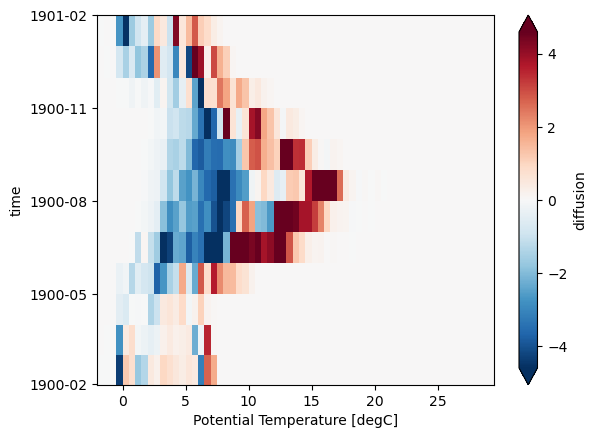

In [23]:
tmp['diffusion'].plot(x="thetao_l_target", robust=True)

In `xwmt`, water mass transformations are defined such that they are positive when they tend to increase the mass of water with tracer values less than the given threshold $\tilde{\lambda}$. For example, $\mathcal{G}^{(Mix)}(5^{\circ}C) < 0$ means that mixing acts to decrease the amount of water that is colder than 5ºC by transforming some of it into waters that are are warmer than 5ºC.

From this analysis, we can see that diffusion generally acts to transform colder waters into warmer ones, and warmer waters into colder ones. This matches our intuition that turbulent mixing acts to homogenize water masses. There is also a seasonal cycle that tracks the net warming and cooling of water masses over the course of the year.

# Part 2. Closed and comprehensive water mass transformation budgets

### Comprehensive budget dictionary

Using the optional utility package `xbudget`, we can read in a pre-configured dictionary that contains comprehensive metadata about the structure of tracer budgets in MOM6. (Please feel free to contribute dictionaries for other models!) This dictionary can also be manually created.

In [24]:
import json
import xbudget
print('xbudget version', xbudget.__version__)

budgets_dict = xbudget.load_preset_budget(model="MOM6")
xbudget.collect_budgets(grid, budgets_dict)

print(json.dumps(budgets_dict['heat'], sort_keys=True, indent=4))

xbudget version 0.2.1


/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


{
    "lambda": "thetao",
    "lhs": {
        "sum": {
            "Eulerian_tendency": {
                "product": {
                    "area": "areacello",
                    "tracer_content_tendency_per_unit_area": "opottemptend",
                    "var": "heat_lhs_sum_Eulerian_tendency_product"
                },
                "var": "heat_lhs_sum_Eulerian_tendency"
            },
            "advection": {
                "sum": {
                    "interfacial": {
                        "product": {
                            "area": "areacello",
                            "sign": -1.0,
                            "tracer_content_tendency_per_unit_area": "Th_tendency_vert_remap",
                            "var": "heat_lhs_sum_advection_sum_interfacial_product"
                        },
                        "var": "heat_lhs_sum_advection_sum_interfacial"
                    },
                    "lateral": {
                        "product": {
                

Note how this nested dictionary structure allows diagnostics which are unavailable in the convenient layer-integrated form of our example above to be derived or approximated from other available variables. For example, consider the advective surface ocean heat flux, which is described by the sub-dictionary

```python
            "surface_ocean_flux_advective_negative_rhs": {
                "product": {
                    "area": "areacello",
                    "density": 1035.0,
                    "lambda_mass": "tos",
                    "sign": -1.0,
                    "specific_heat_capacity": 3992.0,
                    "thickness_tendency": "boundary_forcing_h_tendency",
                    "var": "heat_rhs_sum_surface_ocean_flux_advective_negative_rhs_product"
                },
```

This gives `xbudget` instructions on how to reconstruct the `surface_ocean_flux_advective_negative_rhs` tendency as a product of other terms:
\begin{equation}
-\lambda_{m}Q_{m} \text{d}A = (-1)*(c_{p}*\Theta_{m})*\big(\rho_{0}*\big[\frac{\partial h}{\partial t}\big]_{boundary}\big) * \text{d}A
\end{equation}

By calling `xbudget.collect_budgets`, every derived term in the budget is given a standardized name and lazily added to the dataset `grid._ds`. For example, the lazily-calculated term described above is stored as:

In [25]:
grid._ds['heat_rhs_sum_surface_ocean_flux_advective_negative_rhs_product']

<xarray.DataArray 'heat_rhs_sum_surface_ocean_flux_advective_negative_rhs_product' (
                                                                                    time: 12,
                                                                                    yh: 105,
                                                                                    xh: 97,
                                                                                    zl: 75)> Size: 37MB
dask.array<mul, shape=(12, 105, 97, 75), dtype=float32, chunksize=(1, 105, 97, 75), chunktype=numpy.ndarray>
Coordinates:
  * xh         (xh) float64 776B 6.125 6.375 6.625 6.875 ... 29.62 29.88 30.12
  * yh         (yh) float64 840B 53.01 53.16 53.31 53.46 ... 65.39 65.48 65.56
  * time       (time) object 96B 1900-02-15 00:00:00 ... 1901-01-16 12:00:00
  * zl         (zl) float64 600B 1.0 3.0 5.0 ... 3.338e+03 3.591e+03 5.111e+03
    areacello  (yh, xh) float32 41kB 2.806e+08 2.806e+08 ... 7.357e+07 7.306e+07
    lon        (yh, xh) float32 41kB 6.125 6.375 6.625 ... 29.71 29.96 30.21
    lat        (yh, xh) float32 41kB 53.01 53.01 53.01 ... 65.09 65.08 65.07
Attributes:
    provenance:  [-1.0, 3992.0, 'tos', 'boundary_forcing_h_tendency', 1035.0,...

The full dictionary is daunting, but we don't need every term just to close the water mass transformation budget. We can use the `xbudget.aggregate` function to just pick out the highest-level terms in the budget.

In [26]:
simple_budgets = xbudget.aggregate(budgets_dict)
print(json.dumps(simple_budgets, sort_keys=True, indent=4))

{
    "heat": {
        "lambda": "thetao",
        "lhs": {
            "Eulerian_tendency": "heat_lhs_sum_Eulerian_tendency",
            "advection": "heat_lhs_sum_advection",
            "surface_ocean_flux_advective_negative_lhs": "heat_lhs_sum_surface_ocean_flux_advective_negative_lhs"
        },
        "rhs": {
            "bottom_flux": "heat_rhs_sum_bottom_flux",
            "diffusion": "heat_rhs_sum_diffusion",
            "frazil_ice": "heat_rhs_sum_frazil_ice",
            "surface_exchange_flux": "heat_rhs_sum_surface_exchange_flux",
            "surface_ocean_flux_advective_negative_rhs": "heat_rhs_sum_surface_ocean_flux_advective_negative_rhs"
        },
        "surface_lambda": "tos"
    },
    "mass": {
        "lambda": "density",
        "lhs": {
            "Eulerian_tendency": "mass_lhs_sum_Eulerian_tendency"
        },
        "rhs": {
            "advection": "mass_rhs_sum_advection",
            "surface_exchange_flux": "mass_rhs_sum_surface_exchange_flux"
  

### Redundancy of derived terms

Some terms in the budget, such as the layer-integrated mass tendency due to the convergence of lateral mass transports, can be equivalently derived from two different sets of budget diagnostics:

In [27]:
term = budgets_dict['mass']['rhs']['sum']['advection']['sum']['lateral']
print("As the product of the layer-integrated thickness tendency with density and cell area:")
print(json.dumps(term['product'], sort_keys=True, indent=4), end="\n\n")
print("Or as the sum of the meridional and zonal mass transport convergences, computed from the meridional and zonal mass fluxes on cell faces")
print(json.dumps(term['sum'], sort_keys=True, indent=4))

As the product of the layer-integrated thickness tendency with density and cell area:
{
    "area": "areacello",
    "density": 1035.0,
    "thickness_tendency": "dynamics_h_tendency",
    "var": "mass_rhs_sum_advection_sum_lateral_product"
}

Or as the sum of the meridional and zonal mass transport convergences, computed from the meridional and zonal mass fluxes on cell faces
{
    "meridional_convergence": {
        "product": {
            "meridional_divergence": {
                "difference": {
                    "meridional_mass_transport": "vmo",
                    "var": null
                },
                "var": null
            },
            "sign": -1.0,
            "var": "mass_rhs_sum_advection_sum_lateral_sum_meridional_convergence_product"
        },
        "var": "mass_rhs_sum_advection_sum_lateral_sum_meridional_convergence"
    },
    "var": "mass_rhs_sum_advection_sum_lateral_sum",
    "zonal_convergence": {
        "product": {
            "sign": -1.0,
   

We can plot these to verify that they are indeed equivalent (to machine precision)

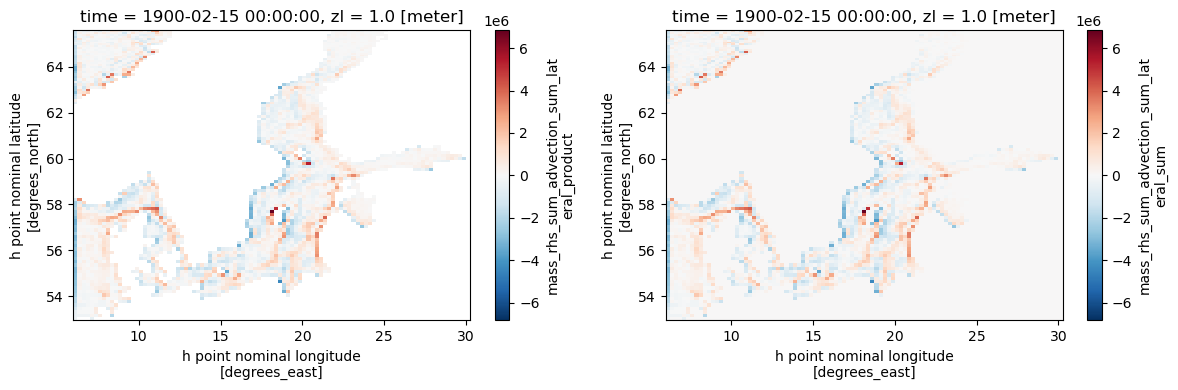

In [28]:
term = budgets_dict['mass']['rhs']['sum']['advection']['sum']['lateral']
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
grid._ds[term['product']['var']].isel(time=0, zl=0).plot()
plt.subplot(1,2,2)
grid._ds[term['sum']['var']].isel(time=0, zl=0).plot()
plt.tight_layout()

### Compute water mass transformations

Finally, we can create an instance of the core `WaterMassTransformations` class and verify that it can find all of the processes we need in the dataset.

In [29]:
wmt = xwmt.WaterMassTransformations(grid, simple_budgets)
sorted(wmt.available_processes())

['Eulerian_tendency',
 'advection',
 'bottom_flux',
 'diffusion',
 'frazil_ice',
 'surface_exchange_flux',
 'surface_ocean_flux_advective_negative_lhs',
 'surface_ocean_flux_advective_negative_rhs']

We use the `integrate_transformations` method to compute area-integrated water mass transformations in the specified coordinate (e.g. `"heat"`).

In [30]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    kwargs = {"sum_components":True, "group_processes":True}
    G_temperature = wmt.integrate_transformations(
        "heat",
        bins=np.arange(-2, 30, 0.25),
        **kwargs
    ).mean('time')
    G_salinity = wmt.integrate_transformations(
        "salt",
        bins=np.arange(0, 50, 0.25),
        **kwargs
    ).mean('time')
    G_density = wmt.integrate_transformations(
        "sigma0",
        bins=np.arange(0, 40, 0.25),
        **kwargs
    ).mean('time')
    
Gs = [G_temperature, G_salinity, G_density]

Process 'frazil_ice' for component salt is unavailable.
Process 'bottom_flux' for component salt is unavailable.


In [31]:
for G in Gs:
    with ProgressBar():
        G.load()

[########################################] | 100% Completed | 3.04 sms
[########################################] | 100% Completed | 2.53 sms
[########################################] | 100% Completed | 1.70 sms


Finally, we can plot the WMT associated with each of the terms and verify that our water mass transformation budgets close:

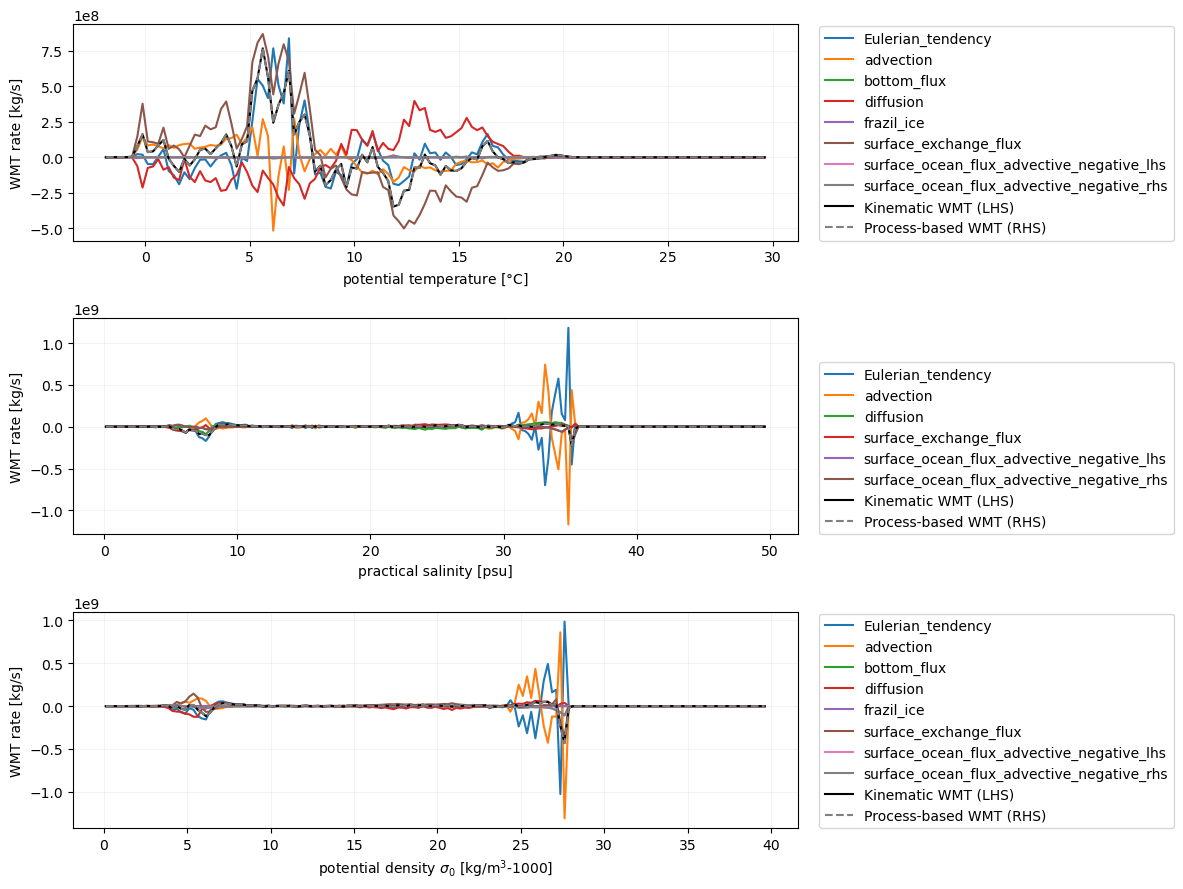

In [32]:
long_names =  [r"potential temperature [$\degree$C]", r"practical salinity [psu]", r"potential density $\sigma_{0}$ [kg/m$^{3}$-1000]"]

plt.figure(figsize=(12, 9))
for i, (G, long_name) in enumerate(zip(Gs, long_names)):
    plt.subplot(3,1,i+1)
    for v in sorted(wmt.available_processes()):
        if v not in G: continue
        G[v].plot(label=v)
    G['kinematic_transformation'].plot(label="Kinematic WMT (LHS)", color="k")
    G['material_transformation'].plot(label="Process-based WMT (RHS)", ls="--", color="grey")
    plt.legend(loc=(1.03, 0.))
    plt.ylabel("WMT rate [kg/s]")
    plt.xlabel(long_name)
    plt.grid(True, alpha=0.15)
plt.tight_layout()

# Part 3. Selectively decomposing budget terms

In density coordinates, there seems to be a dominant balance between diffusion and surface fluxes. Let's break those processes down even further to gain a better understanding.

In [33]:
decomposed_budgets = xbudget.aggregate(budgets_dict, decompose=["diffusion", "surface_exchange_flux", "nonadvective"])
wmt = xwmt.WaterMassTransformations(grid, decomposed_budgets)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    G_density = wmt.integrate_transformations(
        "sigma0",
        bins=np.arange(0, 40, 0.25),
        **kwargs
    ).mean('time')
    with ProgressBar():
        G_density.load()

[########################################] | 100% Completed | 2.69 sms


In [34]:
decomposed_budgets

{'mass': {'lambda': 'density',
  'thickness': 'thkcello',
  'lhs': {'Eulerian_tendency': 'mass_lhs_sum_Eulerian_tendency'},
  'rhs': {'advection': 'mass_rhs_sum_advection',
   'surface_exchange_flux_rain_and_ice': 'mass_rhs_sum_surface_exchange_flux_sum_rain_and_ice',
   'surface_exchange_flux_snow': 'mass_rhs_sum_surface_exchange_flux_sum_snow',
   'surface_exchange_flux_evaporation': 'mass_rhs_sum_surface_exchange_flux_sum_evaporation',
   'surface_exchange_flux_rivers': 'mass_rhs_sum_surface_exchange_flux_sum_rivers',
   'surface_exchange_flux_icebergs': 'mass_rhs_sum_surface_exchange_flux_sum_icebergs',
   'surface_exchange_flux_virtual_precip_restoring': 'mass_rhs_sum_surface_exchange_flux_sum_virtual_precip_restoring'}},
 'heat': {'lambda': 'thetao',
  'surface_lambda': 'tos',
  'lhs': {'Eulerian_tendency': 'heat_lhs_sum_Eulerian_tendency',
   'advection': 'heat_lhs_sum_advection',
   'surface_ocean_flux_advective_negative_lhs': 'heat_lhs_sum_surface_ocean_flux_advective_negative

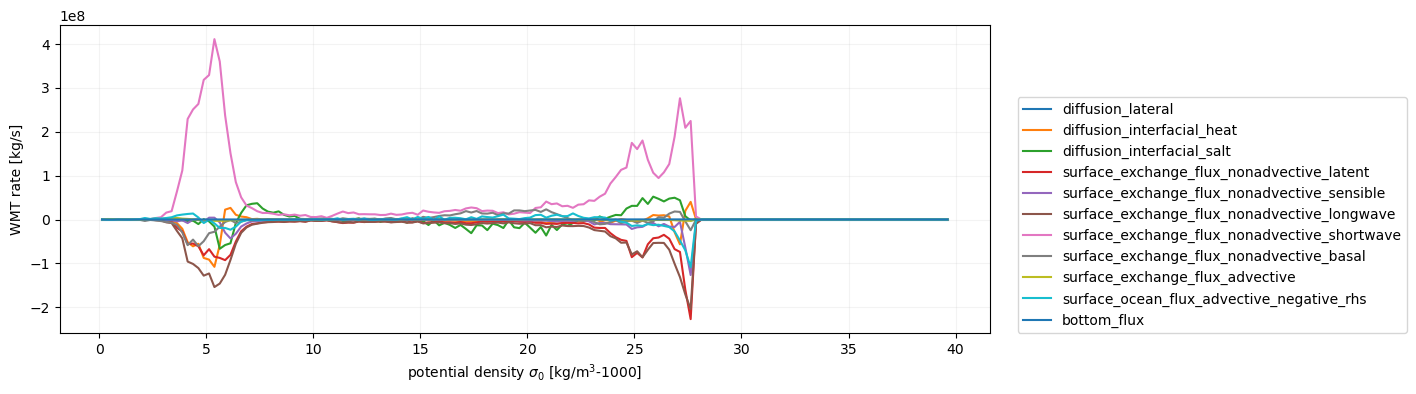

In [35]:
G = G_density
long_name = r"potential density $\sigma_{0}$ [kg/m$^{3}$-1000]"

processes = [
    "diffusion_lateral",
    "diffusion_interfacial_heat",
    "diffusion_interfacial_salt",
    "surface_exchange_flux_nonadvective_latent",
    "surface_exchange_flux_nonadvective_sensible",
    "surface_exchange_flux_nonadvective_longwave",
    "surface_exchange_flux_nonadvective_shortwave",
    "surface_exchange_flux_nonadvective_basal",
    "surface_exchange_flux_advective",
    "surface_ocean_flux_advective_negative_rhs",
    "frazil_heat_tendency",
    "bottom_flux",
]

plt.figure(figsize=(12, 4))
for v in processes:
    if v not in G: continue
    G[v].plot(label=v)
plt.legend(loc=(1.03, 0))
plt.ylabel("WMT rate [kg/s]")
plt.xlabel(long_name)
plt.grid(True, alpha=0.15)

# Part 4. Surface water mass transformations from surface fluxes and surface $\lambda$ only

Suppose no interior information is available, as in the reduced dataset `ds_2d` below for which we have removed any `coord` or `var` that depends on a vertical axis.

In [36]:
ds_2d = ds.copy()
budgets_dict_2d = xbudget.load_preset_budget(model="MOM6")
del budgets_dict_2d['mass']['rhs']['sum']['advection']['sum']['lateral']['sum']

##  Overwrite prefered 3D tendencies with their 2D surface flux equivalents:
# advective surface heat exchange flux
ds_2d['boundary_forcing_h_tendency'] = ds_2d['wfo']/1035.
# assume all solar flux converges in top grid cell
ds_2d['rsdo_surf'] = ds_2d['rsdo'].isel({f"{Zprefix}i":0})
budgets_dict_2d['heat']['rhs']['sum']['surface_exchange_flux']['sum']['nonadvective']['sum']['shortwave'] = {
    "var": None,
    "product": {
        "var": None,
        "tracer_content_tendency_per_unit_area": "rsdo_surf",
        "area": "areacello"
    }
}
# mass flux convergence
budgets_dict_2d['heat']['rhs']['sum']['surface_exchange_flux']['sum']['advective']['var'] = None

## Reconstruct budget terms using the 2D fields
xbudget.collect_budgets(ds_2d, budgets_dict_2d)
decomposed_budgets_2d = xbudget.aggregate(budgets_dict_2d, decompose=["diffusion", "surface_exchange_flux", "nonadvective"])

## Remove 3D coordinates and variables from budgets_dict and dataset
del decomposed_budgets_2d['heat']['lambda']
del decomposed_budgets_2d['salt']['lambda']
del decomposed_budgets_2d['mass']['lambda']

# Drop all vertical coordinates and vertical-dependent variables
ds_2d = ds_2d.drop_vars([f"{Zprefix}l", f"{Zprefix}i"])
for dv in ds_2d.data_vars:
    if (f"{Zprefix}l" in ds_2d[dv].dims) or (f"{Zprefix}i" in ds_2d[dv].dims):
        ds_2d = ds_2d.drop_vars(dv)

# Recreate coordinate and grid objects with 2D dataset
coords_2d = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
}
grid_2d = Grid(
    ds_2d,
    coords=coords_2d,
    metrics=metrics,
    boundary={"X":"extend", "Y":"extend"},
    autoparse_metadata=False
)
        
ds_2d

<xarray.Dataset> Size: 30MB
Dimensions:                                                                    (
                                                                                time: 12,
                                                                                yh: 105,
                                                                                xh: 97,
                                                                                nv: 2,
                                                                                xq: 98,
                                                                                yq: 106)
Coordinates:
  * xh                                                                         (xh) float64 776B ...
  * yh                                                                         (yh) float64 840B ...
  * time                                                                       (time) object 96B ...
  * nv                                                                         (nv) float64 16B ...
  * xq                                                                         (xq) float64 784B ...
  * yq                                                                         (yq) float64 848B ...
    areacello                                                                  (yh, xh) float32 41kB ...
    lon                                                                        (yh, xh) float32 41kB ...
    lat                                                                        (yh, xh) float32 41kB ...
Data variables: (12/66)
    tos                                                                        (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    sos                                                                        (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    hfds                                                                       (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    hflso                                                                      (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    hfsso                                                                      (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    rlntds                                                                     (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    ...                                                                         ...
    salt_rhs_sum_surface_exchange_flux_sum_nonadvective                        (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    salt_rhs_sum_surface_exchange_flux_sum_advective_product                   (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    salt_rhs_sum_surface_exchange_flux_sum_advective                           (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    salt_rhs_sum_surface_exchange_flux_sum                                     (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    salt_rhs_sum_surface_ocean_flux_advective_negative_rhs_product             (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    salt_rhs_sum_surface_ocean_flux_advective_negative_rhs                     (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>

While we can no longer evaluate the full water mass transformation budget, we can still accurately estimate all of the surface water mass transformations terms by assuming the surface fluxes converge in a thin narrow layer and binning these tendencies in $\lambda$ space using the surface $\lambda$ values.

`xwmt` does this automatically when the 3D `lambda` fields are missing from the `budgets_dict` argument of `WaterMassTransformations` and when the tendencies do not depend on any vertical coordinate.

In [37]:
wmt_2d = xwmt.WaterMassTransformations(grid_2d, decomposed_budgets_2d)
sorted(wmt_2d.available_processes())

['surface_exchange_flux_advective',
 'surface_exchange_flux_evaporation',
 'surface_exchange_flux_icebergs',
 'surface_exchange_flux_nonadvective_basal',
 'surface_exchange_flux_nonadvective_latent',
 'surface_exchange_flux_nonadvective_longwave',
 'surface_exchange_flux_nonadvective_sensible',
 'surface_exchange_flux_nonadvective_shortwave',
 'surface_exchange_flux_rain_and_ice',
 'surface_exchange_flux_rivers',
 'surface_exchange_flux_snow',
 'surface_exchange_flux_virtual_precip_restoring',
 'surface_ocean_flux_advective_negative_lhs',
 'surface_ocean_flux_advective_negative_rhs']

In [38]:
wmt_2d.grid._ds

<xarray.Dataset> Size: 30MB
Dimensions:                                                                    (
                                                                                time: 12,
                                                                                yh: 105,
                                                                                xh: 97,
                                                                                nv: 2,
                                                                                xq: 98,
                                                                                yq: 106,
                                                                                z_l: 1,
                                                                                z_i: 2)
Coordinates:
  * xh                                                                         (xh) float64 776B ...
  * yh                                                                         (yh) float64 840B ...
  * time                                                                       (time) object 96B ...
  * nv                                                                         (nv) float64 16B ...
  * xq                                                                         (xq) float64 784B ...
  * yq                                                                         (yq) float64 848B ...
    areacello                                                                  (yh, xh) float32 41kB ...
    lon                                                                        (yh, xh) float32 41kB ...
    lat                                                                        (yh, xh) float32 41kB ...
  * z_l                                                                        (z_l) float64 8B ...
  * z_i                                                                        (z_i) float64 16B ...
Data variables: (12/69)
    tos                                                                        (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    sos                                                                        (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    hfds                                                                       (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    hflso                                                                      (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    hfsso                                                                      (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    rlntds                                                                     (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    ...                                                                         ...
    salt_rhs_sum_surface_exchange_flux_sum                                     (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    salt_rhs_sum_surface_ocean_flux_advective_negative_rhs_product             (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    salt_rhs_sum_surface_ocean_flux_advective_negative_rhs                     (time, yh, xh) float32 489kB dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    h                                                                          (z_l) int64 8B ...
    h_i                                                                        (z_i) float64 16B ...
    z                                                                          (z_l) float64 8B ...

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    G_2d = wmt_2d.integrate_transformations("sigma0", bins=np.arange(0, 40, 0.25));
    with ProgressBar():
        G_2d.load();

[########################################] | 100% Completed | 427.06 ms


In [40]:
decomposed_budgets_2d

{'mass': {'thickness': 'thkcello',
  'lhs': {'Eulerian_tendency': 'mass_lhs_sum_Eulerian_tendency'},
  'rhs': {'advection': 'mass_rhs_sum_advection',
   'surface_exchange_flux_rain_and_ice': 'mass_rhs_sum_surface_exchange_flux_sum_rain_and_ice',
   'surface_exchange_flux_snow': 'mass_rhs_sum_surface_exchange_flux_sum_snow',
   'surface_exchange_flux_evaporation': 'mass_rhs_sum_surface_exchange_flux_sum_evaporation',
   'surface_exchange_flux_rivers': 'mass_rhs_sum_surface_exchange_flux_sum_rivers',
   'surface_exchange_flux_icebergs': 'mass_rhs_sum_surface_exchange_flux_sum_icebergs',
   'surface_exchange_flux_virtual_precip_restoring': 'mass_rhs_sum_surface_exchange_flux_sum_virtual_precip_restoring'}},
 'heat': {'surface_lambda': 'tos',
  'lhs': {'Eulerian_tendency': 'heat_lhs_sum_Eulerian_tendency',
   'advection': 'heat_lhs_sum_advection',
   'surface_ocean_flux_advective_negative_lhs': 'heat_lhs_sum_surface_ocean_flux_advective_negative_lhs'},
  'rhs': {'diffusion_lateral': 'heat_

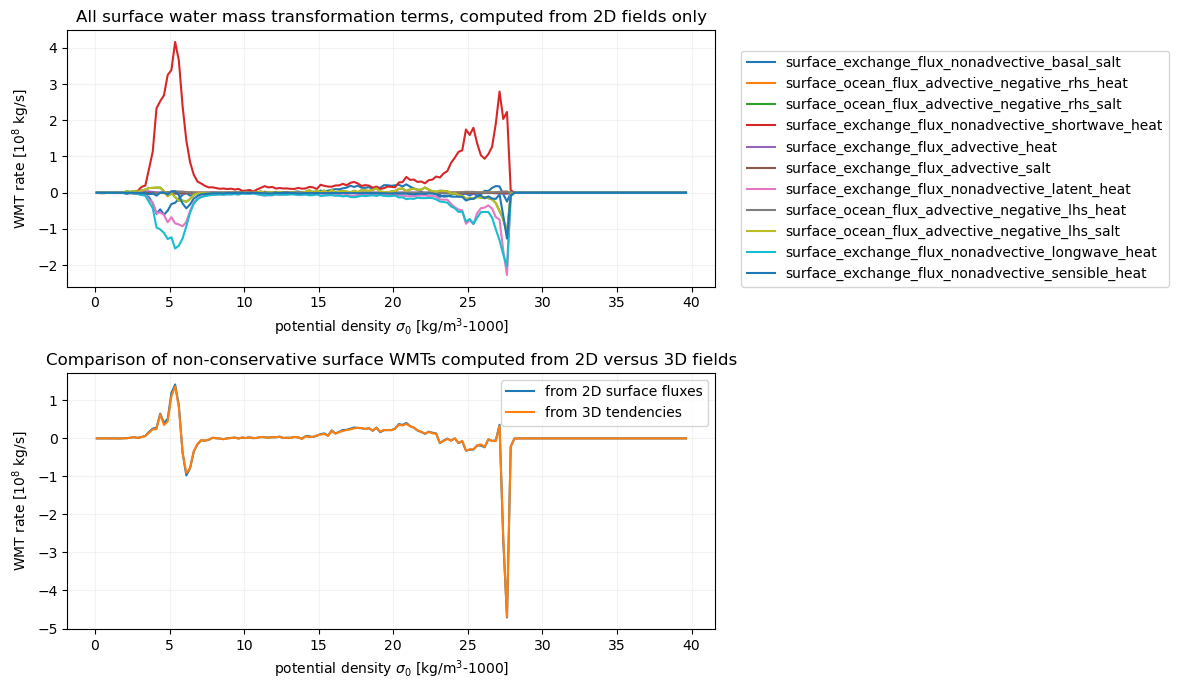

In [41]:
plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
for v in G_2d:
    if ("salt" not in v) and ("heat" not in v):
        continue
    (G_2d[v]*1e-8).mean('time').plot(label=v)
plt.legend(loc=(1.04, 0))
plt.ylabel("WMT rate [$10^{8}$ kg/s]")
plt.xlabel(r"potential density $\sigma_{0}$ [kg/m$^{3}$-1000]")
plt.grid(True, alpha=0.15)
plt.title("All surface water mass transformation terms, computed from 2D fields only")

plt.subplot(2,1,2)
(sum([G_2d[v] for v in G_2d.data_vars if ("lhs" not in v) and ("heat" not in v) and ("salt" not in v)])*1e-8).mean('time').plot(label="from 2D surface fluxes")
(sum([G_density[v] for v in G_density.data_vars if ("lhs" not in v) and ("surface" in v) and (("heat" not in v) and ("salt" not in v))])*1e-8).plot(label="from 3D tendencies")
plt.legend()
plt.ylabel("WMT rate [$10^{8}$ kg/s]")
plt.xlabel(r"potential density $\sigma_{0}$ [kg/m$^{3}$-1000]")
plt.grid(True, alpha=0.15)
plt.title("Comparison of non-conservative surface WMTs computed from 2D versus 3D fields")
plt.tight_layout()

# Part 5: Mapping spatial patterns of water mass transformation 

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    G_2d_iso = (
        wmt_2d.map_transformations("sigma0", bins=np.arange(0, 40, 0.25))
        .sel(sigma0_l_target=6, method="nearest")
        .mean('time')
    );
    with ProgressBar():
        G_2d_iso.load();

/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/transform.py:46

[########################################] | 100% Completed | 1.03 sms


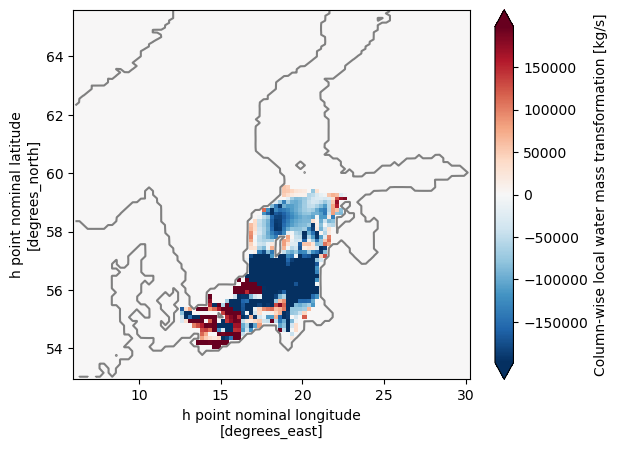

In [43]:
pc = sum([
    G_2d_iso[p] for p in sorted(wmt_2d.available_processes())
    if ("rhs" in p) | (("advective" not in p) ^ ("surface_exchange_flux" in p))
]).plot(robust=True)
pc.colorbar.set_label(r"Column-wise local water mass transformation [kg/s]")
ct = ocean_grid['deptho'].fillna(0.).plot.contour(levels=[1], colors="gray")
plt.title("");